In [1]:
import os
import numpy as np
from PIL import Image
import csv
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

2024-09-03 15:49:20.466835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Code for face detection

In [2]:
# Load the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [3]:
folder = "/Users/apple/Downloads/dataset/litty"

In [4]:
valid_image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')  

In [5]:

if os.path.isdir(folder):
    for i in os.listdir(folder):
        if i.lower().endswith(valid_image_extensions):
            img_path = os.path.join(folder,i)
            image = cv2.imread(img_path)
            

            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Detect faces in the image
            faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.4, minNeighbors=10, minSize=(30, 30))

            # Check if a face is detected
            if len(faces) > 0:
                # Get the coordinates of the first face detected (x, y, w, h)
                for n in range(len(faces)):

                    

                    (x, y, w, h) = faces[n]

                    # Crop the face from the image
                    face_crop = image[y:y+h, x:x+w]

                    # Convert BGR (OpenCV default) to RGB (for matplotlib)
                    face_crop_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

                    # Display the cropped face
                    plt.imshow(face_crop_rgb)
                    plt.title(img_path)
                    plt.axis('off')  # Hide axis
                    plt.show()


else:
    print("No face detected.")


### Implementing CNN for the prepared dataset:

In [32]:
import pandas as pd

In [33]:
df = pd.read_csv("image_dataset.csv")

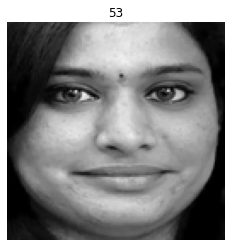

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image


# Convert the pixel values to numeric, handling any errors
image_data = pd.to_numeric(df.iloc[40, 1:], errors='coerce')

# Ensure there are no NaN values by replacing them with 0 (or an appropriate value)
image_data = image_data.fillna(0)

# Reshape the flattened array into a 128x128 image
image_array = image_data.values.reshape(128, 128)

# Plot the image
plt.imshow(image_array, cmap='gray')  # Assuming the image is grayscale
plt.title(df.iloc[34,34])  # Display the label as the title
plt.axis('off')  # Hide the axis
plt.show()


In [34]:

# Extract Labels and Features:

labels = df['Label']
pixel_data = df.drop(columns=['Label'])
pixel_data = pixel_data.values
labels = labels.values


In [35]:

# Reshape the Image Data:
# Assuming each image is 128x128 pixels:

height, width = 128, 128
num_channels = 1  # For grayscale images. Use 3 for RGB images.

# Reshape the pixel data
images = pixel_data.reshape((-1, height, width, num_channels))


In [36]:

images = images.astype('float32') / 255.0


In [37]:

# Encode Labels:
# Convert categorical labels to numeric values if needed.

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


In [38]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=50)


In [39]:
y_test.shape

(9,)

In [40]:
# Converting class vectors to binary class matrices (one-hot encoding)
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [41]:
y_test

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2


# Defining the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1), kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compiling the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printing the model summary
model.summary()


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,838 (12.61 MB)

 Trainable params: 3,304,838 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# training 

model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2069 - loss: 2.1721 - val_accuracy: 0.0000e+00 - val_loss: 2.7646
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.2069 - loss: 2.1889 - val_accuracy: 0.0000e+00 - val_loss: 2.2920
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.2414 - loss: 2.2736 - val_accuracy: 0.0000e+00 - val_loss: 2.2340
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.2759 - loss: 2.0156 - val_accuracy: 0.0000e+00 - val_loss: 2.2050
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.2759 - loss: 2.0676 - val_accuracy: 0.0000e+00 - val_loss: 2.2152
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4483 - loss: 1.9522 - val_accuracy: 0.0000e+00 - val_loss: 2.2920
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5172 - loss: 1.9214 - val_accuracy: 0.0000e+00 - val_loss: 2.4382
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5172 - loss: 1.8653 - val_acc

#### we have very less data so we see the accuracy to be 100% which is overfitting. 
#### Let us augument the data to artificially increase the size of the training dataset by 
#### applying transformations like rotations, flips, and shifts.

In [19]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
# Train the model
history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=test_dataset)

Epoch 1/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.5101 - loss: 2.4220 - val_accuracy: 0.4444 - val_loss: 1.9779
Epoch 2/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3368 - loss: 2.7537 - val_accuracy: 0.3333 - val_loss: 2.3388
Epoch 3/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3368 - loss: 2.4771 - val_accuracy: 0.2222 - val_loss: 2.7149
Epoch 4/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3876 - loss: 2.3876 - val_accuracy: 0.1111 - val_loss: 2.7762
Epoch 5/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3570 - loss: 2.7699 - val_accuracy: 0.1111 - val_loss: 2.4274
Epoch 6/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3264 - loss: 2.4236 - val_accuracy: 0.1111 - val_loss: 2.1666
Epoch 7/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2958 - loss: 2.2663 - val_accuracy: 0.1111 - val_loss: 1.8179
Epoch 8/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2345 - loss: 1.9861 - val_accuracy: 0.2222 - val_loss: 1.742

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6326 - loss: 1.3666 - val_accuracy: 0.5556 - val_loss: 1.6816
Epoch 53/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6326 - loss: 1.3846 - val_accuracy: 0.5556 - val_loss: 1.4945
Epoch 54/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5713 - loss: 1.6760 - val_accuracy: 0.6667 - val_loss: 1.2822
Epoch 55/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7244 - loss: 0.9464 - val_accuracy: 0.6667 - val_loss: 1.2130
Epoch 56/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6326 - loss: 1.1122 - val_accuracy: 0.6667 - val_loss: 1.1467
Epoch 57/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7857 - loss: 0.9259 - val_accuracy: 0.6667 - val_loss: 1.1085
Epoch 58/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7244 - loss: 0.9492 - val_accuracy: 0.7778 - val_loss: 1.0455
Epoch 59/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8163 - loss: 0.8504 - val_accuracy: 0.7778 - val_loss: 1.0645
Epoc

In [21]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7778 - loss: 1.1057
Test accuracy: 77.78%


We require a lot of data to make the classifications. Let us proceed looking at models that are pre defined on 
other datasets so that we can easily work on limited local datasets.

### Google's inception v1 

In [42]:
#Importing the basic librarires

import cv2
import math
import keras
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer
from keras import backend as K 
from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten

In [23]:
# Preparing the Dataset

num_classes = 6
img_rows,img_cols = 128, 128



# Resize images to 244x244
X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:][:3000]])
X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:,:,:][:3000]])
y_train = y_train[:3000]
y_test = y_test[:3000]

# Transform targets to keras compatible format
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Making all the values range between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((33, 128, 128), (33, 6, 6), (9, 128, 128), (9, 6, 6))

In [24]:
# Model development

def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,
    filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    return output

kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [25]:
input_layer = Input(shape=(128, 128, 1))

# Correct the name fields by replacing '/' with '_'
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7_2')(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3_2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3_1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3_1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3_2')(x)

# Inception modules (unchanged)
x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32, name='inception_3a')
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, name='inception_3b')

# MaxPooling (unchanged)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3_2')(x)

# Inception modules and auxiliary output 1
x = inception_module(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64, name='inception_4a')
x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(6, activation='softmax', name='auxilliary_output_1')(x1)  # Changed to 6 classes

# Continue the Inception modules
x = inception_module(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4b')
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4c')
x = inception_module(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64, name='inception_4d')

# Auxiliary output 2
x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(6, activation='softmax', name='auxilliary_output_2')(x2)  # Changed to 6 classes

# Continue the final Inception modules
x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_4e')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3_2')(x)
x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_5a')
x = inception_module(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128, name='inception_5b')

# Final output layer
x = GlobalAveragePooling2D(name='avg_pool_5_3x3_1')(x)
x = Dropout(0.4)(x)
x = Dense(6, activation='softmax', name='output')(x)  # Changed to 6 classes

# Defining the model
model = Model(input_layer, [x, x1, x2], name='inception_v1')

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Checking Model Summary
model.summary()


Model: "inception_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_7x7_2        │ (None, 64, 64,    │      3,200 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_1_3x3_2    │ (None, 32, 32,    │          0 │ conv_1_7x7_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2a_3x3_1       │ (None, 32, 32,    │      4,160 │ max_pool_1_3x3_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2b_3x3_1       │ (None, 32, 32,    │    110,784 │ conv_2a_3x3_1[0]… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_2_3x3_2    │ (None, 16, 16,    │          0 │ conv_2b_3x3_1[0]… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,528 │ max_pool_2_3x3_2… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │      3,088 │ max_pool_2_3x3_2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ max_pool_2_3x3_2… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     12,352 │ max_pool_2_3x3_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │      6,176 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a        │ (None, 16, 16,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │     32,896 │ inception_3a[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │      8,224 │ inception_3a[0][… │
│                     │ 32)               │            │                 

 Total params: 7,169,730 (27.35 MB)

 Trainable params: 7,169,730 (27.35 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Plotting the model architecture
# i have used "pip install pydot graphviz"
plot_model(model, to_file="my_model.png", show_shapes=True)

In [27]:
 hisroty =model.compile(optimizer='adam', 
              loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
              metrics=[['accuracy'], ['accuracy'], ['accuracy']])

In [28]:
model.compile(optimizer='adam', 
              loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
              metrics=[['accuracy'], ['accuracy'], ['accuracy']])

In [29]:
history = model.fit(X_train, [y_train, y_train, y_train],
                    validation_data=(X_test, [y_test, y_test, y_test]),
                    epochs=5, 
                    batch_size=256)

Epoch 1/5


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 6, 6), output.shape=(None, 6)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
model.compile(optimizer='adam', 
              loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
              loss_weights=[1.0, 0.3, 0.3],  # Lower weight for auxiliary outputs
              metrics=[['accuracy'], ['accuracy'], ['accuracy']])

Loading pre trained google model


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

preprocessor = AutoImageProcessor.from_pretrained("google/mobilenet_v1_1.0_224")
model = AutoModelForImageClassification.from_pretrained("google/mobilenet_v1_1.0_224")

inputs = preprocessor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
curl -O https://repo.anaconda.com/miniconda/Miniconda3-latest-MacOSX-x86_64.sh
sh Miniconda3-latest-MacOSX-x86_64.sh

In [ ]:
history = model.fit(X_train, [y_train, y_train, y_train],
                    validation_data=(X_test, [y_test, y_test, y_test]),
                    epochs=5, 
                    batch_size=256)

Inception v3

In [31]:
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

# Load the InceptionV3 model without the top layer (used for ImageNet classification)
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer for classification
x = Dense(1024, activation='relu')(x)

# Output layer for 6 classes (using softmax)
predictions = Dense(6, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [56]:
from keras.preprocessing.image import ImageDataGenerator

# Define image data generator for preprocessing and augmenting the small dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    rotation_range=20,  # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/Users/apple/Downloads/dataset',  # Path to your training dataset
    target_size=(299, 299),
    batch_size=4,  # You have a small dataset, so small batch size
    class_mode='categorical'
)

NameError: name 'train_datagen' is not defined

In [53]:
pip install keras


Note: you may need to restart the kernel to use updated packages.
